200×3 Matrix{Float64}:
  0.831139   4.65506   -1.0
 -1.90546    4.5143    -1.0
  3.40616    4.13149    1.0
  5.84181    0.488536   1.0
  1.10003   -0.838716   1.0
  2.01409   -4.27256    1.0
  2.46589    4.10409    1.0
  2.35983    3.79286    1.0
  3.96282    3.35423    1.0
  5.09901    2.20719    1.0
  ⋮                    
  3.16502    6.33641   -1.0
  1.41073    1.96949    1.0
  6.31159    2.46764    1.0
  6.59225   -0.331738   1.0
 -0.111499   2.1388     1.0
  1.64298    4.1928     1.0
  0.978371   3.91175    1.0
  0.836612   6.33656   -1.0
 -0.644302   4.51195   -1.0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

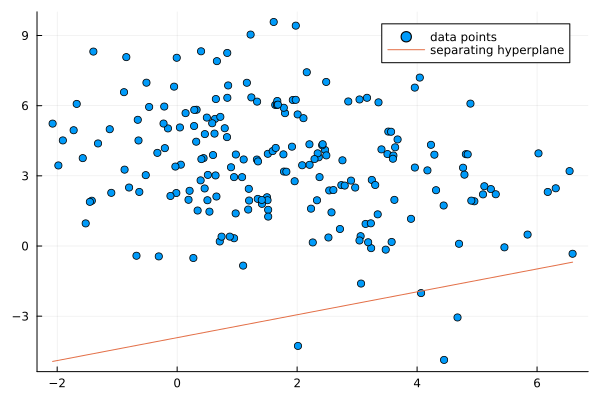

In [1]:
using LinearAlgebra, JuMP, Ipopt, DelimitedFiles, Plots

"""
    a, b = softSvm(X, y; lambda=1e6)

Computes a soft-SVM linear classifier, using IPOPT in JuMP to solve a convex QP.

Written by Kamil Khan on March 16, 2024, for CHEMENG 4H03

# Inputs

- `X`: a matrix of training data points. The i^th row of `X` is the i^th point.
- `y`: a vector of labels for the training data. Each `y[i]` must be either `-1.0` or `1.0`.
- `lambda=1e6`: the strictness/hardness of the soft threshold. Preferably large, and must be `> 0.0`

# Outputs

- `a` and `b`: classifier's hyperplane coefficients. Ideally, many training data points `(x,y)` should satisfy `y*(dot(a, x) - b) > 0.0`.
"""
function softSvm(X, y; lambda=1e3)
    nPoints = length(y)  # number of training points
    dimX = size(X, 2)    # dimension of each training point

    # initialize the optimization problem in JuMP
    problem = Model(Ipopt.Optimizer)

    # set up decision variables, which the optimization problem aims to choose
    @variable(problem, a[1:dimX])
    @variable(problem, b)
    @variable(problem, xi[1:nPoints] >= 0.0)

    # set up an objective function, which the optimization problem aims to minimize
    @objective(problem, Min, dot(a, a) + lambda*sum(xi))

    # set up constraints, which the optimization problem's solution must satisfy
    @constraint(problem, softThreshold[i=1:nPoints],
                y[i]*(dot(a, X[i,:]) - b) >= 1.0 - xi[i])

    # solve the optimization problem in JuMP
    optimize!(problem)

    # convert solutions from JuMP objects to vectors/scalars
    aStar = value.(a)
    bStar = value.(b)

    return aStar, bStar
end

# test the function
using DelimitedFiles
#test code
separable_data = readdlm("separable.csv", ',')
display(separable_data)
#X = first column
x = separable_data[:,1]
#y = second column
y = separable_data[:,2]
#combine x and y into a matrix for data points
dataPoints = hcat(x, y)

labels = separable_data[:,3]
a, b = softSvm(dataPoints, labels)
println("a = ", a)
println("b = ", b)
#plot the data points and the separating hyperplane
using Plots
scatter(x, y, label="data points")
plot!(x -> (a[1]*x + b)/(-a[2]), label="separating hyperplane")

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9999980e+03 9.90e-01 1.47e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

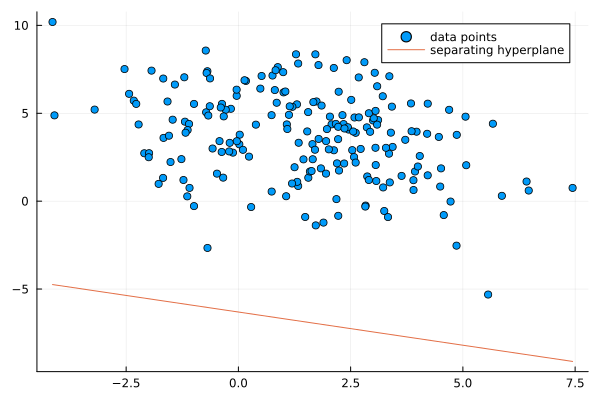

In [2]:
#now with non-separable data
non_separable_data = readdlm("notSeparable.csv", ',')

x = non_separable_data[:,1]
y = non_separable_data[:,2]
dataPoints = hcat(x, y)
labels = non_separable_data[:,3]
a, b = softSvm(dataPoints, labels)
println("a = ", a)
println("b = ", b)
scatter(x, y, label="data points")
plot!(x -> (a[1]*x + b)/(-a[2]), label="separating hyperplane")


This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9999980e+03 9.90e-01 1.47e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

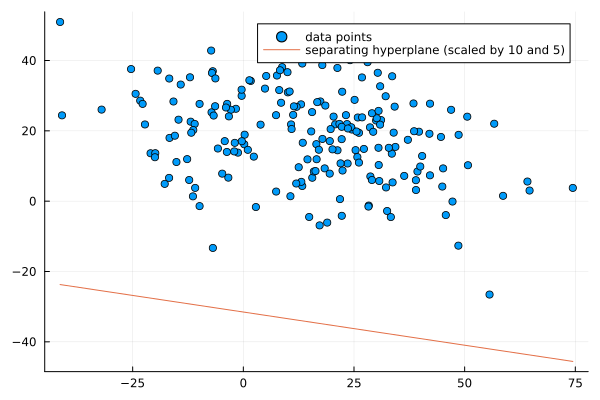

In [3]:
#multiply x by 10 and y by 5 and repeat
x = non_separable_data[:,1]*10
y = non_separable_data[:,2]*5
dataPoints = hcat(x, y)
a, b = softSvm(dataPoints, labels)
println("a = ", a)
println("b = ", b)
scatter(x, y, label="data points")
plot!(x -> (a[1]*x + b)/(-a[2]), label="separating hyperplane (scaled by 10 and 5)")